In [1]:
# Load Packages

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import os
import numpy as np
import networkx as nx
import itertools
import copy
import datetime, time


from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
from numpy import array 

In [2]:
#Import Dataset

filename = '/Users/Geoff/Desktop/MMAI/CAPSTONE/aragon-all-votes_outcome feature.csv'
df = pd.read_csv(filename)

In [3]:
#Prepare data

df['vote'] = df['vote'].eq('Yes').astype(int)
df['Result'] = df['Result'].eq('Yes').astype(int)
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
df['timestamp'] = df['timestamp'].values.astype(np.float)

In [4]:
#Normalise data across votes

#group by vote 
df_vote  = df.groupby('voting_number')
print(type(df_vote))

#normalise timestamps and stake amount across groups
df['timestamp_norm'] = df.groupby('voting_number')['timestamp'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
df['staked_norm'] = df.groupby('voting_number')['staked_ANT_amount'].apply(lambda x: (x-x.min())/(x.max()-x.min()))

<class 'pandas.core.groupby.groupby.DataFrameGroupBy'>


# Vote 11

In [5]:
#Get Data From Vote 1 for calulation
df = df[(df['voting_number']==10)]

In [6]:
votes = df[['timestamp_norm','staked_norm']]

In [7]:
votes 

,timestamp_norm,staked_norm
357,0.000000,0.000017
358,0.002237,0.042541
359,0.014009,0.030196
360,0.016147,0.005150
361,0.016611,0.000126
362,0.017476,0.000120
363,0.021771,0.005048
364,0.028878,0.081030
365,0.046650,0.000698
366,0.046984,0.000144


In [8]:
#Calculate the Gini-Coefficient of votes (Adapted from: https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation)

time = votes['timestamp_norm'].values
staked = votes['staked_norm'].values

In [9]:
#Definie Gini Function

def gini(staked, time):
    assert (len(staked) == len(time))
    all = np.asarray(np.c_[staked, time, np.arange(len(time))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(staked) + 1) / 2.
    return giniSum / len(staked)


def gini_normalized(staked, time):
    return gini(staked, time) / gini(staked, time)

gini_time = gini(staked, time)
gini_max = gini(staked, time)
ngini= gini_normalized(staked, time)
print('Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_time, gini_max, ngini))

Gini: 0.193, Max. Gini: 0.193, Normalized Gini: 1.000


In [10]:
# Sort the actual values by the staked
data = zip(staked, time)
sorted_data = sorted(data, key=lambda d: d[1])
sorted_actual = [d[0] for d in sorted_data]
print('Sorted Actual Values', sorted_actual)

Sorted Actual Values [1.722610100845169e-05, 0.04254142251442935, 0.03019617689540134, 0.005150149540335011, 0.0001261644830947384, 0.00012012719410277488, 0.005047578970230381, 0.08103014387643236, 0.0006978315722986076, 0.0001439334580680787, 0.0004417449642253488, 0.00059836179362726, 6.240585065643411e-05, 6.243900265106448e-06, 0.0019069997103590695, 0.10437515962667089, 0.22124053117029013, 0.09668560545039523, 0.09668560545039523, 0.0072738629489868525, 0.09668560545039523, 0.08491535860166655, 0.006311541913254702, 0.0004276279291199008, 0.0011115140857194982, 0.00025075565704510335, 0.0, 0.014126079782483163, 0.10098568625243781, 0.0025245761396873773, 0.00661841703233633, 0.005612361608879683, 0.004632805232270797, 0.039510608528194914, 0.0004733030123384098, 0.00028150572596711204, 0.00027563368751304124, 0.005917783498780535, 0.000356455208756232, 1.1946125670166827e-06, 0.020892791589304877, 0.06311602851676457, 0.0005048610604514709, 0.0037868980642098184, 0.0252463707810

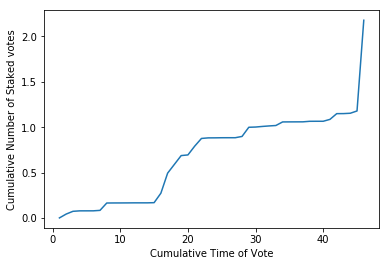

In [11]:
# Sum up the actual values
cumulative_actual = np.cumsum(sorted_actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1)

plt.plot(cumulative_index, cumulative_actual)
plt.xlabel('Cumulative Time of Vote')
plt.ylabel('Cumulative Number of Staked votes')
plt.show()

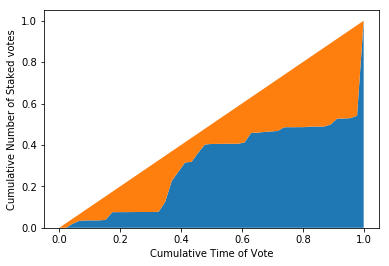

In [12]:
cumulative_actual_votes = cumulative_actual / sum(staked)
cumulative_index_time = cumulative_index / len(time)

# Add (0, 0) to the plot
x_values = [0] + list(cumulative_index_time)
y_values = [0] + list(cumulative_actual_votes)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values)]

plt.stackplot(x_values, y_values, diagonal)
plt.xlabel('Cumulative Time of Vote')
plt.ylabel('Cumulative Number of Staked votes')
plt.show()